In [1]:
import os
import numpy as np
import pandas as pd 
import random
import cv2
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import warnings

from random import shuffle 
from tqdm import tqdm 
from PIL import Image
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, SeparableConv2D, MaxPool2D, LeakyReLU, Activation
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm

%matplotlib inline

in_path = '../input/chest-xray-pneumonia//chest_xray/chest_xray/'

Using TensorFlow backend.


In [2]:
def extract_data(dimensions, batch_length):
    tgen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, vertical_flip=True)
    test_val_datagen = ImageDataGenerator(rescale=1./255)
    tgen_final = tgen.flow_from_directory(directory=in_path+'train', target_size=(dimensions, dimensions), batch_size=batch_length, class_mode='binary', shuffle=True)
    test_gen = test_val_datagen.flow_from_directory(directory=in_path+'test', target_size=(dimensions, dimensions), batch_size=batch_length, class_mode='binary', shuffle=True)

    test_data = []
    test_labels = []
    
    train_data = []
    train_labels = []

    for normal_image in (os.listdir(in_path + 'test' + '/NORMAL/')):
        normal_image = plt.imread(in_path+'test'+'/NORMAL/'+normal_image)
        normal_image = cv2.resize(normal_image, (dimensions, dimensions))
        normal_image = normal_image.astype('float32') / 255
        label = 0
        test_data.append(normal_image)
        test_labels.append(label)

    for pneumonia_image in (os.listdir(in_path + 'test' + '/PNEUMONIA/')):
        pneumonia_image = plt.imread(in_path+'test'+'/PNEUMONIA/'+pneumonia_image)
        pneumonia_image = cv2.resize(pneumonia_image, (dimensions, dimensions))
        pneumonia_image = pneumonia_image.astype('float32') / 255
        label = 1
        test_data.append(pneumonia_image)
        test_labels.append(label)

    for normal_image in (os.listdir(in_path + 'train' + '/NORMAL/')):
        if normal_image == '.DS_Store':
            continue
        normal_image = plt.imread(in_path+'train'+'/NORMAL/'+normal_image)
        normal_image = cv2.resize(normal_image, (dimensions, dimensions))
        normal_image = normal_image.astype('float32') / 255
        label = 0
        train_data.append(normal_image)
        train_labels.append(label)

    for pneumonia_image in (os.listdir(in_path + 'train' + '/PNEUMONIA/')):
        if pneumonia_image == '.DS_Store':
            continue
        pneumonia_image = plt.imread(in_path+'train'+'/PNEUMONIA/'+pneumonia_image)
        pneumonia_image = cv2.resize(pneumonia_image, (dimensions, dimensions))
        pneumonia_image = pneumonia_image.astype('float32') / 255
        label = 1
        train_data.append(pneumonia_image)
        train_labels.append(label)
    
    return tgen_final, test_gen, test_data, test_labels, train_data, train_labels

In [3]:
img_dims = 150
epochs = 3
batch_size = 10

train_gen, test_gen, test_data, test_labels, train_data, train_labels = extract_data(img_dims, batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
flat_train_data = []
flat_test_data = []

for img in train_data: 
    flat_train_data.append(img.flatten())
    
for img in test_data: 
    flat_test_data.append(img.flatten())

In [5]:
listed_train_data = []
listed_test_data = []

for d in flat_train_data:
    listed_train_data.append(d.tolist()[:150*150])
    
for d in flat_test_data:
    listed_test_data.append(d.tolist()[:150*150])

In [6]:
train_labels_mini = train_labels
test_labels_mini = test_labels

In [7]:
clf = svm.SVC()
prediction = clf.fit(listed_train_data, train_labels_mini)

/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [8]:
correctlyPredicted = 0
fp = 0
tp = 0
fn = 0
tn = 0

for ind in range(len(listed_test_data)): 
    pred = clf.predict([listed_test_data[ind]])
    real = test_labels_mini[ind]
    if real == 1 and pred == 1:
        tp += 1
    if real == 1 and pred == 0:
        fn += 1
    if real == 0 and pred == 1:
        fp += 1
    if real == 0 and pred == 0:
        tn += 1
    if pred == real:
        correctlyPredicted += 1

acc = correctlyPredicted/float(len(listed_test_data))
print("TEST DATA________________________")
print("Accuracy: {}".format(acc))
print("Confusion matrix: f_p = {}, t_p = {}, f_n = {}, t_n = {}".format(fp, tp, fn, tn))

prec = tp/(tp+fp)*100
rec = tp/(tp+fn)*100
print("Precision: {}, recall: {}".format(prec, rec))

TEST DATA________________________
Accuracy: 0.75
Confusion matrix: f_p = 150, t_p = 384, f_n = 6, t_n = 84
Precision: 71.91011235955057, recall: 98.46153846153847


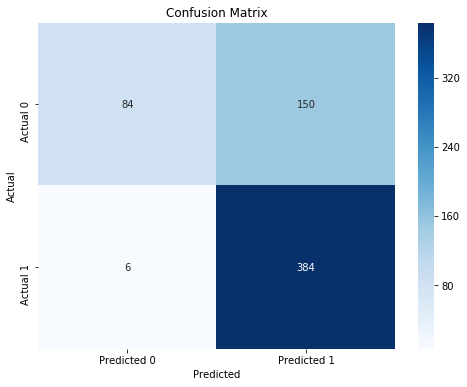

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix values
fp = 150
tp = 384
fn = 6
tn = 84

# Create confusion matrix
cm = [[tn, fp], [fn, tp]]

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


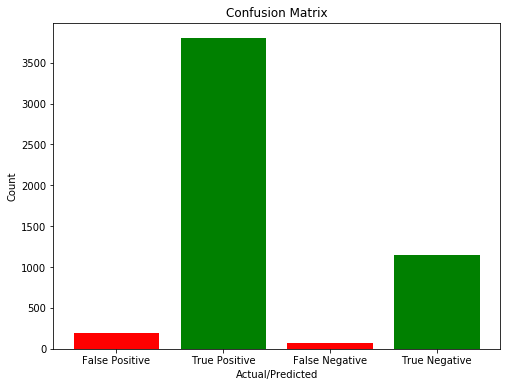

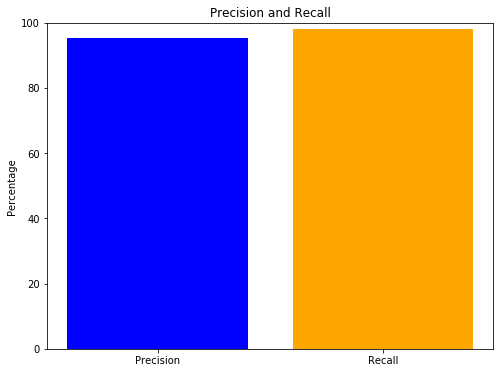

In [10]:
import matplotlib.pyplot as plt

# Data
conf_matrix = [fp, tp, fn, tn]
labels = ['False Positive', 'True Positive', 'False Negative', 'True Negative']
metrics = [prec, rec]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.bar(labels, conf_matrix, color=['red', 'green', 'red', 'green'])
plt.title('Confusion Matrix')
plt.xlabel('Actual/Predicted')
plt.ylabel('Count')
plt.show()

# Plot precision and recall
plt.figure(figsize=(8, 6))
plt.bar(['Precision', 'Recall'], metrics, color=['blue', 'orange'])
plt.title('Precision and Recall')
plt.ylabel('Percentage')
plt.ylim([0, 100])
plt.show()


In [9]:
correctlyPredicted = 0
fp = 0
tp = 0
fn = 0
tn = 0

for ind in range(len(listed_train_data)): 
    pred = clf.predict([listed_train_data[ind]])
    real = train_labels_mini[ind]
    if real == 1 and pred == 1:
        tp += 1
    if real == 1 and pred == 0:
        fn += 1
    if real == 0 and pred == 1:
        fp += 1
    if real == 0 and pred == 0:
        tn += 1
    if pred == real:
        correctlyPredicted += 1

acc = correctlyPredicted/float(len(listed_train_data))
print("TRAIN DATA________________________")
print("Accuracy: {}".format(acc))
print("Confusion matrix: f_p = {}, t_p = {}, f_n = {}, t_n = {}".format(fp, tp, fn, tn))

prec = tp/(tp+fp)*100
rec = tp/(tp+fn)*100
print("Precision: {}, recall: {}".format(prec, rec))

TRAIN DATA________________________
Accuracy: 0.9495782208588958
Confusion matrix: f_p = 188, t_p = 3800, f_n = 75, t_n = 1153
Precision: 95.28585757271816, recall: 98.06451612903226
